### Overview
You are building a basic version of GPT using PyTorch. This involves:
- Implementing single-head attention.
- Expanding it to multi-head attention.
- Understanding concepts like queries, keys, values, masking, and softmax.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

### Components to build
- Vanilla decoder model
- XL Transformer model
- kNN memory (add/remove functionality)
- kNN attention layer
- T5 relative position bias


- "We used a 12-layer decoder-only transformer (with and without Transformer-XL cache) with an embedding size of 1024, 8 attention heads of dimension 128, and an FFN hidden layer of size 4096. For all of our experiments, we used k = 32. Unless specified otherwise, we use the 9th layer as the kNN augmented attention layer. We used a sentence-piece (Kudo & Richardson, 2018) tokenizer with a vocabulary size of 32K."

# Building GPT

# Single head attention

### Step 1: Define Dimensions

- sequence_length: Number of tokens in a sentence (e.g., words or subwords).
- embedding_dimension: Size of the vector used to represent each token.
- head_dimension: Size of each attention head in multi-head attention.
- number_heads: Number of attention heads (we’re simulating multi-head attention later).
- scaling_factor: A small adjustment for stabilizing training. Dividing by the square root of head dimension helps normalize the dot product of queries and keys.

#### Attention Head:
An attention head is part of the multi-head attention mechanism. In a transformer model, the self-attention mechanism allows the model to focus on different parts of the input sequence when producing an output. Instead of having a single attention mechanism that looks at the entire sequence at once, the model has multiple attention heads, each one focusing on different aspects or relationships between tokens.

Multiple heads enable the model to attend to different parts of the input sequence simultaneously, each head focusing on different patterns or features. For instance, one head may focus on syntactic relationships (like subject-verb agreement), while another head might focus on semantic relationships (like entity recognition).

Each attention head computes a weighted sum of the input values (i.e., tokens) based on their relevance to the current token being processed.

The intuition is that by using multiple attention heads, the model can capture a richer set of relationships in the data, leading to improved performance.

#### Head Size:
The head size refers to the size of the vectors used by each individual attention head. In transformer models, the input is split into several parts (one for each head) before performing attention. The head size is the dimension of each part, and it determines how much information each attention head processes.

For example, if the total model dimension is d_model and there are h attention heads, then the head size is typically d_model / h. Each attention head will work with vectors of size d_model / h to calculate its attention values.

In [2]:
# Sample numbers
sequence_length = 512
embedding_dimension = 300
head_dimension = 32
number_heads = 8
batch_size = 16
scaling_factor = head_dimension ** -0.5

### Step 2: Create Fake Input Data

- You’re creating a random tensor to simulate input data. This mimics embeddings of a batch of words (tokens).
- Shape: (sequence_length, embedding_dimension) — one row per token, each represented by a 300-dimensional vector.

In [3]:
# Single batch fake training data
input_data = torch.randn((sequence_length, embedding_dimension))
input_data.shape

torch.Size([512, 300])

### Step 3: Define Query, Key, and Value (QKV) Matrices

- QKV Matrices: Linear transformations to extract queries, keys, and values from the input embeddings.
    - Queries ask: "What am I focusing on?"
    - Keys answer: "Do I match this focus?"
    - Values provide: "What information should I output?"
- The shape of these matrices is (embedding_dimension, number_heads * head_dimension).

`nn.Linear` is a function in PyTorch that defines a **fully connected (dense) layer** in a neural network. It is part of the `torch.nn` module and is used to apply a linear transformation to the input data. This transformation involves multiplying the input by a weight matrix and then adding a bias term, which is a common operation in many machine learning models, including deep neural networks.

### Syntax:
```python
nn.Linear(in_features, out_features, bias=True)
```

- **in_features**: The number of input features (dimensions of the input vector).
- **out_features**: The number of output features (dimensions of the output vector).
- **bias** (optional): If `True`, the layer will include a bias term. Default is `True`.

### What It Does:
When you apply `nn.Linear` to an input tensor, it computes the following transformation for each input vector \(x\):

\[
y = xW^T + b
\]

- \(W\) is the weight matrix with shape \((\text{out\_features}, \text{in\_features})\).
- \(b\) is the bias vector with shape \((\text{out\_features})\).
- \(y\) is the output vector, having the shape \((\text{batch\_size}, \text{out\_features})\), assuming the input tensor has the shape \((\text{batch\_size}, \text{in\_features})\).


In [4]:
# KQV transforms
query_matrix = nn.Linear(embedding_dimension, number_heads * head_dimension)
key_matrix = nn.Linear(embedding_dimension, number_heads * head_dimension)
value_matrix = nn.Linear(embedding_dimension, number_heads * head_dimension)
query_matrix

Linear(in_features=300, out_features=256, bias=True)

### Step 4: Transform Input into Queries, Keys, and Values

- Each input token is passed through the QKV linear transformations to produce vectors.
- Resulting shapes: (sequence_length, number_heads * head_dimension). This combines all attention heads.

In [5]:
# Create KQV matrices with input data
queries = query_matrix(input_data)
keys = key_matrix(input_data)
values = value_matrix(input_data)

In [6]:
queries.shape

torch.Size([512, 256])

In [7]:
keys.shape

torch.Size([512, 256])

In [8]:
keys = keys.transpose(-1, -2)
keys.shape

torch.Size([256, 512])

In [9]:
qk = queries @ keys
qk.shape

torch.Size([512, 512])

In [10]:
qk = qk / torch.sqrt(torch.tensor(256)) # sqrt(key_dimension)

### Example for QKV attention scoring

The attention_plot function visualizes attention scores or masked attention scores using heatmaps, helping you see how much attention each token gives to others.

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def attention_plot(qk, labels, title=None):

    plt.figure(figsize=(8, 6))
    im = plt.imshow(qk, cmap='Greens')

    plt.xticks(ticks=np.arange(qk.shape[0]), labels=labels)
    plt.yticks(ticks=np.arange(qk.shape[0]), labels=labels)
    plt.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    # Adding x and y axis labels with a bigger font size
    plt.xlabel('KEYS', fontsize=14, labelpad=20)  # X-axis label at the top
    plt.ylabel('QUERIES', fontsize=14)
    plt.title(title, fontsize=20)

    # Adjust the position of the x-axis label to the top
    plt.gca().xaxis.set_label_position('top')

    for i in range(qk.shape[0]):
        for j in range(qk.shape[1]):
            text = plt.text(j, i, f'{qk[i, j]:.2f}',
                        ha="center", va="center", color="b")

    # Adding a colorbar
    plt.colorbar(im)

    # Displaying the plot
    plt.show()

In [12]:
labels = ["A", "DOG", "IS", "AN", "ANIMAL"]
toy_qk = torch.tensor([[.900, 0.300, 0.00, 0.100, 0.000],
        [0.600, 2.00, 0.100, 0.2000, 1.9000],
        [0.00, 0.200, 1.00, 0.100, 0.0500],
        [0.0500, 0.0000, 0.100, 0.9500, .5000],
        [0.000, 1.8000, 0.0000, .4000, 2.1000]])

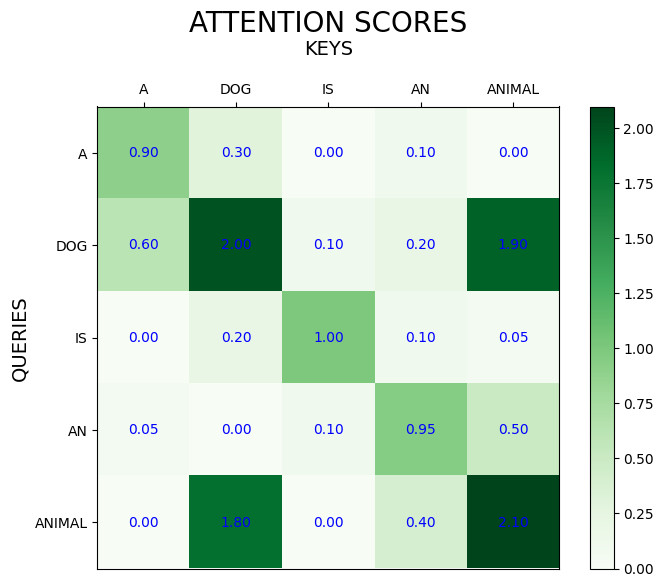

In [13]:
# QK
attention_plot(toy_qk, labels, "ATTENTION SCORES")

In [14]:
j, i = 5, 5
mask = torch.ones((j,i), dtype=torch.bool)
mask

tensor([[True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True]])

In [15]:
mask = mask.triu(1)
mask

tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])

In [16]:
toy_qk_masked = toy_qk.masked_fill(mask, float('-inf'))
toy_qk_masked

tensor([[0.9000,   -inf,   -inf,   -inf,   -inf],
        [0.6000, 2.0000,   -inf,   -inf,   -inf],
        [0.0000, 0.2000, 1.0000,   -inf,   -inf],
        [0.0500, 0.0000, 0.1000, 0.9500,   -inf],
        [0.0000, 1.8000, 0.0000, 0.4000, 2.1000]])

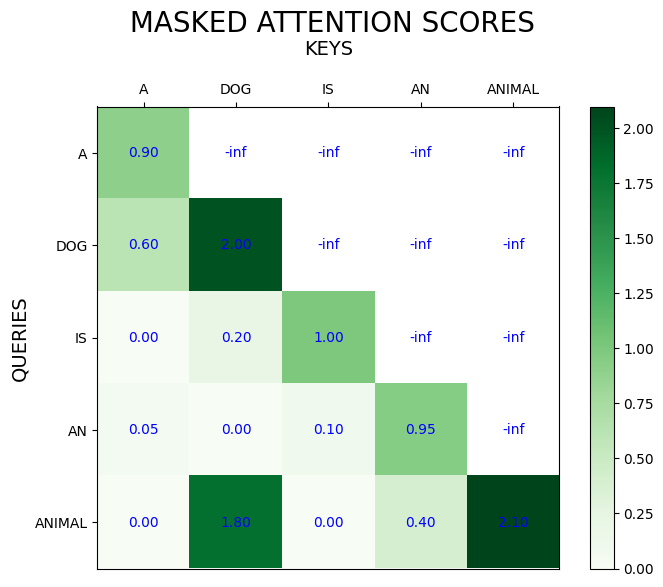

In [17]:
attention_plot(toy_qk_masked, labels, " MASKED ATTENTION SCORES")

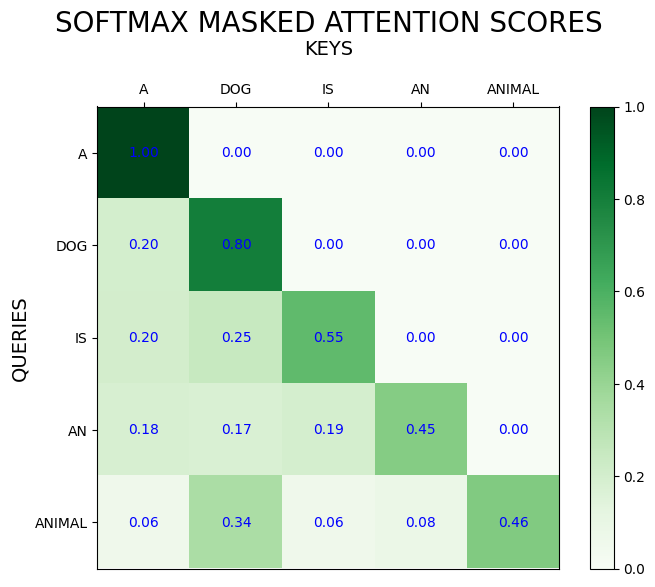

In [18]:
# APPLY SOFTMAX
toy_qk_softmax = torch.nn.functional.softmax(toy_qk_masked, dim=-1)
attention_plot(toy_qk_softmax, labels, "SOFTMAX MASKED ATTENTION SCORES")

In [19]:
# last row
toy_qk_softmax[-1]

tensor([0.0565, 0.3416, 0.0565, 0.0842, 0.4612])

In [23]:
# "A"  "DOG" "IS"  "AN" "ANIMAL"
#  v1,  v2,   v3,   v4,   v5

# "ANIMAL" output vector =
#  .06 * v1 ("A") +
#  .34 * v2 ("DOG") +
#  .06 * v3 ("IS") +
#  .08 * v4 ("AN") +
#  .46 * v5 ("ANIMAL")

In [20]:
qk.shape

torch.Size([512, 512])

In [21]:
mask = torch.ones((qk.shape[-1], qk.shape[-1]), dtype = torch.bool).triu(1)
qk_masked = qk.masked_fill(mask, float('-inf'))
qk_masked

tensor([[-0.2973,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
        [-0.1286, -0.4562,    -inf,  ...,    -inf,    -inf,    -inf],
        [ 0.3335,  0.0190, -0.3455,  ...,    -inf,    -inf,    -inf],
        ...,
        [-0.2962,  0.0210, -0.0460,  ...,  0.2175,    -inf,    -inf],
        [-0.3814, -0.1518,  0.8152,  ..., -0.2710,  0.3081,    -inf],
        [ 0.4509, -0.0303, -0.0837,  ...,  0.0706, -0.3447, -1.3686]],
       grad_fn=<MaskedFillBackward0>)

In [22]:
qk_softmax = F.softmax(qk_masked, dim=-1)
qk_softmax

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.8118e-01, 4.1882e-01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.4698e-01, 3.2635e-01, 2.2667e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.3765e-03, 1.8902e-03, 1.7678e-03,  ..., 2.3007e-03, 0.0000e+00,
         0.0000e+00],
        [1.2692e-03, 1.5969e-03, 4.1999e-03,  ..., 1.4174e-03, 2.5293e-03,
         0.0000e+00],
        [3.0207e-03, 1.8669e-03, 1.7698e-03,  ..., 2.0653e-03, 1.3633e-03,
         4.8968e-04]], grad_fn=<SoftmaxBackward0>)

In [23]:
print ("qk:", qk.shape)
print ("values:", values.shape)

qk: torch.Size([512, 512])
values: torch.Size([512, 256])


In [24]:
# Compute qkv
qkv = qk@values
qkv.shape

torch.Size([512, 256])

# Multihead attention

In [25]:
# Sample numbers
sequence_length = 512
embedding_dimension = 300
head_dimension = 32
number_heads = 8
batch_size = 16
scaling_factor = head_dimension ** -0.5

In [26]:
# Create fake training batch
input_data = torch.randn((batch_size, sequence_length, embedding_dimension))
input_data.shape

torch.Size([16, 512, 300])

In [27]:
# KQ transforms
query_matrix = nn.Linear(embedding_dimension, number_heads * head_dimension)
key_matrix = nn.Linear(embedding_dimension, number_heads * head_dimension)
value_matrix = nn.Linear(embedding_dimension, number_heads * head_dimension)
query_matrix

Linear(in_features=300, out_features=256, bias=True)

### Step 1: Transform Input into Queries, Keys, and Values

- Each input token is passed through the QKV linear transformations to produce vectors.
- Resulting shapes: (sequence_length, number_heads * head_dimension). This combines all attention heads.

In [28]:
# Create KQ matrices with input data
queries = query_matrix(input_data)
keys = key_matrix(input_data)
values = value_matrix(input_data)
queries.shape

torch.Size([16, 512, 256])

### Step 2: Reshape for Multi-Head Attention

- Reshape: Splits the combined attention heads into separate "heads."
- Transpose: Rearranges dimensions to match the required attention calculation format:
    - q becomes (batch_size, number_heads, sequence_length, head_dimension).
    - k becomes (batch_size, number_heads, head_dimension, sequence_length).

In [29]:
# Separate queries matrix into heads for multi-head attention
q = queries.reshape(batch_size, sequence_length, number_heads, head_dimension)
# Separate keys matrix into heads for multi-head attention
k = keys.reshape(batch_size, sequence_length, number_heads, head_dimension)
# Separate keys matrix into heads for multi-head attention
v = values.reshape(batch_size, sequence_length, number_heads, head_dimension)
q.shape

torch.Size([16, 512, 8, 32])

In [30]:
q = q.transpose(1,2)
q.shape

torch.Size([16, 8, 512, 32])

In [31]:
k.shape

torch.Size([16, 512, 8, 32])

In [32]:
k = k.transpose(1,2) # This transposes the tensor k by swapping the dimensions at index 1 and 2
k.shape

torch.Size([16, 8, 512, 32])

In [33]:
k = k.transpose(-1,-2) # This line transposes the tensor again, but instead of using explicit indices, it uses the last two dimensions (-1 refers to the last dimension and -2 refers to the second-to-last dimension).
k.shape

torch.Size([16, 8, 32, 512])

### Step 3: Compute Attention Scores

- Dot Product (@): Computes similarity between queries and keys. Each score tells how much a query focuses on a key.
- Scaling Factor: Normalizes scores to avoid large numbers during training.

In [34]:
qk = q@k

print ("queries:", q.shape)
print ("keys:", k.shape)
print ("qk:", qk.shape)

queries: torch.Size([16, 8, 512, 32])
keys: torch.Size([16, 8, 32, 512])
qk: torch.Size([16, 8, 512, 512])


In [35]:
qk = qk * scaling_factor

### Step 4: Apply Mask

- Masking: Blocks information from "future" tokens (tokens the model hasn’t seen yet). This ensures that predictions are based only on previous tokens.
- masked_fill: Replaces masked positions with -inf so their softmax probabilities become zero.

In [36]:
mask = torch.ones((qk.shape[-1], qk.shape[-1]), dtype = torch.bool).triu(1)
qk_masked = qk.masked_fill(mask, float('-inf'))

### Step 5: Softmax Normalization

- Converts raw attention scores into probabilities (values between 0 and 1).
- Ensures that scores across all keys for a query sum to 1.

In [38]:
qk_softmax = F.softmax(qk_masked, dim=-1)
qk_softmax.shape

torch.Size([16, 8, 512, 512])

In [39]:
v.shape

torch.Size([16, 512, 8, 32])

In [40]:
v = v.transpose(1,2)
v.shape

torch.Size([16, 8, 512, 32])

### Step 6: Weighted Summation (Output Vectors)

Attention Output: Combines the values (v) based on the attention scores. Each token's output vector is a weighted sum of all value vectors.

In [41]:
qkv = qk@v
qkv.shape

torch.Size([16, 8, 512, 32])

### Step 6: Handling the Output of Attention

- Transpose: This swaps the dimensions to adjust the tensor to the correct shape for concatenation of the multi-head attention output.
- Reshape: After transposing, we combine the results of all attention heads. So, instead of having separate vectors for each head, we stack them together into one single tensor.

In [42]:
qkv = qkv.transpose(1,2)
qkv.shape

torch.Size([16, 512, 8, 32])

In [45]:
# Concatenate heads
qkv = qkv.reshape(batch_size, sequence_length, number_heads * head_dimension)
qkv.shape

torch.Size([16, 512, 256])

### Step 7: Output Matrix (Final Transformation)

This Linear layer maps the combined output of all heads back to the embedding dimension of the model. This ensures that the resulting tensor will be compatible with further processing steps in the network.

Feedforward Output: We pass the tensor (containing all the attention outputs) through the output_matrix. This step adjusts the size of the attention output to match the input size of the model, making it ready for further layers.

In [46]:
# the output matrix converts our data out of attention and out for a feedforward layer
output_matrix = nn.Linear(number_heads * head_dimension, embedding_dimension)
output_matrix

Linear(in_features=256, out_features=300, bias=True)

In [47]:
out = output_matrix(qkv)
out.shape

torch.Size([16, 512, 300])

# Attention class and Mini GPT

### Multi-Head Attention Class (MHAttention)

This class implements multi-head attention. Here's a breakdown:
- Heads & Head Dimension: The number of attention heads (heads) and the dimension of each head (head_dimension) are set during initialization.
- QKV matrices: These are the linear layers that create the queries, keys, and values from the input embeddings.
- Scale: The scaling factor (head_dimension ** -0.5) is used to stabilize training by adjusting the dot products of the queries and keys.

Forward Pass:
- The input tensor x is passed through the QKV layers, generating queries, keys, and values for attention calculation.
- Shape of queries, keys, and values: (batch_size, sequence_length, heads * head_dimension)

Split Into Attention Heads
- Reshaping: This step breaks down the QKV outputs into individual attention heads. Each head will handle a part of the attention mechanism, allowing the model to focus on different aspects of the input sequence simultaneously.

Transpose for Matrix Multiplication
- Transpose: This changes the order of dimensions so that the heads and sequence length align correctly for matrix multiplication (q @ k).
- Final Transpose of Keys: This transposes the keys to align them for the dot product calculation with queries.

Compute Attention Scores
- Dot Product: We perform the dot product (q @ k) to compute the similarity between the queries and keys. The result gives us the attention scores.
- Scaling: The scaling factor helps avoid excessively large dot product values that could destabilize training.

Masking and Softmax
- Masking: To prevent the model from "seeing" future tokens in a sequence (important for autoregressive models like GPT), a mask is applied to set the attention scores of future tokens to -inf (effectively making them have no influence).
- Softmax: This converts the attention scores into probabilities, where higher values indicate more focus on certain tokens.

Apply Attention to Values
- Apply Attention: Multiply the attention weights (qk) by the values (v) to get the weighted sum, which is the final attention output.
- Transpose & Reshape: We restore the tensor to its correct shape, combining all attention heads into a single output tensor.

Output Transformation
- The final output from multi-head attention is passed through a linear layer (output_matrix) to map it back to the original embedding dimension.

In [48]:
class MHAttention(nn.Module):
    def __init__(
        self,
        embedding_dimension,
        heads = 8,
        head_dimension = 32,
    ):
        super().__init__()
        self.heads = heads
        self.head_dimension = head_dimension
        self.scale = head_dimension ** -0.5

        self.query_matrix = nn.Linear(embedding_dimension, heads * head_dimension)
        self.key_matrix = nn.Linear(embedding_dimension, heads * head_dimension)
        self.value_matrix = nn.Linear(embedding_dimension, heads * head_dimension)
        self.output_matrix = nn.Linear(heads * head_dimension, embedding_dimension)

    def forward(
        self,
        x, # batch_size, sequence_length, embedding_dimension
    ):
        batch_size, sequence_length = x.shape[:2]
        queries = self.query_matrix(x)
        keys = self.key_matrix(x)
        values = self.value_matrix(x)

        # Separate  into heads for multi-head attention
        k = keys.reshape(batch_size, sequence_length, self.heads, self.head_dimension)
        q = queries.reshape(batch_size, sequence_length, self.heads, self.head_dimension)
        v = values.reshape(batch_size, sequence_length, self.heads, self.head_dimension)

        # Swap head and sequence length dimensions
        q = q.transpose(1,2)
        k = k.transpose(1,2)
        v = v.transpose(1,2)
        # Rearrange keys to prepare for matrix multiplication q@k
        k = k.transpose(2,3)

        # QK
        qk = q@k
        qk = qk * self.scale

        ############
        # TODO
        # qk = relative_positiion_values + qk
        ############

        i, j = qk.shape[-2:]
        mask = torch.ones((i,j), dtype = torch.bool).triu(j-i+1)
        qk = qk.masked_fill(mask, float('-inf'))

        qk = F.softmax(qk, dim=-1)

        qkv = qk@v
        qkv = qkv.transpose(1,2)
        qkv = qkv.reshape(batch_size, sequence_length, self.heads * self.head_dimension)

        out = self.output_matrix(qkv)

        return out

In [49]:
input_data = torch.randn(16,512,300)

mha = MHAttention(300, heads=8, head_dimension=32)

output = mha(input_data)
output.shape

torch.Size([16, 512, 300])

# Building a Mini GPT Model

- Mini GPT: This part builds a simple GPT-like model with:
    - Embedding Layer: Converts token indices into vectors (size 64 in this case).
    - Multiple MHAttention Layers: Stacks multiple multi-head attention layers to allow deeper understanding of the sequence.
    - Feedforward Layers: These layers transform the attention output through nonlinear activations (ReLU).
    - Final Linear Layer: Outputs the logits, which will be used for predicting the next token.
- CrossEntropyLoss: This is used for training the model. It calculates the loss between the predicted token probabilities and the actual token.

In [50]:
# GPT MINI!
model = nn.Sequential(
    nn.Embedding(128,64), # (vocab_size, embedding_dim)

    MHAttention(64, heads=4, head_dimension=16),
    nn.LayerNorm(64),
    nn.Linear(64,100),
    nn.ReLU(),
    nn.Linear(100,64),

    MHAttention(64, heads=4, head_dimension=16),
    nn.LayerNorm(64),
    nn.Linear(64,100),
    nn.ReLU(),
    nn.Linear(100,64),

    MHAttention(64, heads=4, head_dimension=16),
    nn.LayerNorm(64),
    nn.Linear(64,100),
    nn.ReLU(),
    nn.Linear(100,64),

    nn.Linear(64, 128) # (params, vocab_size)
    )

loss_fn = nn.CrossEntropyLoss()


# Pytorch topics and internals

### Multiplying matrices in pytorch

In PyTorch, several functions are available for performing matrix and tensor multiplications, each tailored to different use cases. Here's a breakdown of the primary functions you mentioned:
- torch.mul() is for element-wise multiplication.
- torch.dot() is for the dot product of 1D tensors.
- torch.mm() is for matrix multiplication with 2D tensors.
- torch.bmm() is for batch matrix multiplication with 3D tensors.
- torch.matmul() is for general matrix multiplication, with support for broadcasting across higher-dimensional tensors.
- The @ operator is a convenient shorthand for matrix multiplication, equivalent to torch.matmul().

These functions are optimized for performance and flexibility, making PyTorch a powerful tool for deep learning.

In [ ]:
torch.mul()
# Elementwise multiplication (Hadamard): This performs element-wise multiplication of two tensors, i.e., it multiplies corresponding elements in the tensors.
# Broadcasts: If the tensors have different shapes, PyTorch will automatically "broadcast" the smaller tensor to match the shape of the larger one, provided the dimensions are compatible.

torch.dot()
# Computes the dot product of two 1D tensors: This calculates the dot product of two 1D tensors, which is equivalent to performing element-wise multiplication and summing the results.
# No broadcasting: Both tensors must be 1D and of the same length.

torch.mm()
# Matrix multiplication of two 2D matrices: Matrix multiplication for two 2D matrices (i.e., A @ B where A is of size (n, m) and B is of size (m, p)).
# Does not broadcast: Both matrices must be 2D, and the number of columns in the first matrix must match the number of rows in the second.

torch.bmm()
# Batch matrix multiplication of two 3D matrices: (b, n, m) x (b, m, p) = (b, n, p): This function performs batch matrix multiplication. It operates on 3D tensors, where each slice (along the batch dimension) is a separate matrix multiplication.
# Does not broadcast: Each batch must have tensors of matching dimensions for matrix multiplication.

torch.matmul()
# General matrix multiplication for tensors of any size. Depending on the inputs will perform dot, mm, bmm (broadcasted to any tensor size): This is the most flexible function, handling a wide variety of input shapes, including:
# - 1D x 1D dot product
# - 2D x 2D matrix multiplication
# - 3D x 3D batch matrix multiplication
# Broadcasts: Broadcasting support for higher-dimensional tensors. This function can automatically handle broadcasting if the tensors have compatible shapes.

@
# Same as matmul(). The @ (at) operator is intended to be used for matrix multiplication. No builtin Python types implement this operator.

### Broadcasting

Broadcasting refers to the ability of PyTorch to automatically expand smaller tensors to match the shape of larger tensors in certain operations, without the need for explicit repetition or tiling. This makes element-wise operations more flexible and efficient.

### Broadcasting Rules
Two tensors are broadcastable if:
- Each tensor has at least one dimension.
- When comparing dimensions starting from the trailing (last) dimension, the dimensions must either be:
    - Equal, or
    - One of them is 1, or
    - One tensor does not have that dimension.
If these conditions are met, PyTorch will implicitly expand the smaller tensor along the dimensions where it has size 1, and perform the operation.

Two tensors are “broadcastable” if the following rules hold:

- Each tensor has at least one dimension.
- When iterating over the dimension sizes, starting at the trailing dimension,
the dimension sizes must either be equal, one of them is 1, or one of them does not exist.

https://pytorch.org/docs/stable/notes/broadcasting.html
https://numpy.org/devdocs/user/basics.broadcasting.html#general-broadcasting-rules

An operation that uses broadcasting makes ASSUMPTIONS about what you intend to do.

1. Mismatched Dimensions: Broadcasting happens when performing matrix multiplication

In [52]:
a = torch.randn(1, 64, 1152, 1, 8)
b = torch.randn(10, 1, 1152, 8, 16)

# @ applies broadcasting to a and b
c = a @ b
print(c.size())

torch.Size([10, 64, 1152, 1, 16])


In [53]:
a = torch.randn(1, 64, 1152, 1, 8)
b = torch.randn(8, 16)

# @ applies broadcasting to a and b
c = a @ b
print(c.size())

torch.Size([1, 64, 1152, 1, 16])


In [55]:
# Without broadcasting:
# Have to apply repeat, expand, tiling operations...to make the right tensor shapes

a = torch.arange(4)
print ("a:", a)

b = torch.ones(8,4)
print ("b:", b)

a = a.expand(8,4)
print ("a expanded:", a)

print ("b + a:", b+a)

a: tensor([0, 1, 2, 3])
b: tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
a expanded: tensor([[0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3]])
b + a: tensor([[1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.]])


2. Basic Broadcasting: When adding two tensors with mismatched dimensions, broadcasting automatically adjusts the shape

In [56]:
# With broadcasting:
# Automatic!
a = torch.arange(4)
b = torch.ones(8,4)

print (b + a)

tensor([[1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.]])


In [57]:
# Be careful!

# Broadcasting assumes things you might not intend

# Instead of an error, it will automatically reshape your tensors and perform the oepration

# https://github.com/pytorch/pytorch/issues/16045

loss = nn.MSELoss()
input = torch.randn(1, 3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = loss(input, target)
output

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([3, 5])) that is different to the input size (torch.Size([1, 3, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(3.2673, grad_fn=<MseLossBackward0>)

### Multidimensional Matmuls

The operations involving multi-dimensional matrices such as a @ b can be used for batch processing where tensors are multiplied across different dimensions. This applies to 3D and 4D tensors as well.

In [58]:
# MULTIPLY 3D TENSORS
a = torch.ones(3,2,2)
a[0,] = 3
a[1,] = 4
a[2,] = 5
b = torch.ones(3,2,2)
b[0,] = 6
b[1,] = 7
b[2,] = 8

In [59]:
a

tensor([[[3., 3.],
         [3., 3.]],

        [[4., 4.],
         [4., 4.]],

        [[5., 5.],
         [5., 5.]]])

In [60]:
b

tensor([[[6., 6.],
         [6., 6.]],

        [[7., 7.],
         [7., 7.]],

        [[8., 8.],
         [8., 8.]]])

In [61]:
a@b

tensor([[[36., 36.],
         [36., 36.]],

        [[56., 56.],
         [56., 56.]],

        [[80., 80.],
         [80., 80.]]])

3. Broadcasting in Higher-Dimensional Matrices: When multiplying higher-dimensional matrices (3D, 4D, etc.), PyTorch will apply broadcasting rules to ensure dimensions align for operations like matrix multiplication.

In [62]:
# MULTIPLY 4D TENSORS
a = torch.ones(4,3,2,2)
a[0,] = 3
a[1,] = 4
a[2,] = 5
a[3,] = 6
b = torch.ones(4,3,2,2)
b[0,] = 7
b[1,] = 8
b[2,] = 9
b[3,] = 10

In [63]:
a

tensor([[[[3., 3.],
          [3., 3.]],

         [[3., 3.],
          [3., 3.]],

         [[3., 3.],
          [3., 3.]]],


        [[[4., 4.],
          [4., 4.]],

         [[4., 4.],
          [4., 4.]],

         [[4., 4.],
          [4., 4.]]],


        [[[5., 5.],
          [5., 5.]],

         [[5., 5.],
          [5., 5.]],

         [[5., 5.],
          [5., 5.]]],


        [[[6., 6.],
          [6., 6.]],

         [[6., 6.],
          [6., 6.]],

         [[6., 6.],
          [6., 6.]]]])

In [64]:
b

tensor([[[[ 7.,  7.],
          [ 7.,  7.]],

         [[ 7.,  7.],
          [ 7.,  7.]],

         [[ 7.,  7.],
          [ 7.,  7.]]],


        [[[ 8.,  8.],
          [ 8.,  8.]],

         [[ 8.,  8.],
          [ 8.,  8.]],

         [[ 8.,  8.],
          [ 8.,  8.]]],


        [[[ 9.,  9.],
          [ 9.,  9.]],

         [[ 9.,  9.],
          [ 9.,  9.]],

         [[ 9.,  9.],
          [ 9.,  9.]]],


        [[[10., 10.],
          [10., 10.]],

         [[10., 10.],
          [10., 10.]],

         [[10., 10.],
          [10., 10.]]]])

In [65]:
a@b

tensor([[[[ 42.,  42.],
          [ 42.,  42.]],

         [[ 42.,  42.],
          [ 42.,  42.]],

         [[ 42.,  42.],
          [ 42.,  42.]]],


        [[[ 64.,  64.],
          [ 64.,  64.]],

         [[ 64.,  64.],
          [ 64.,  64.]],

         [[ 64.,  64.],
          [ 64.,  64.]]],


        [[[ 90.,  90.],
          [ 90.,  90.]],

         [[ 90.,  90.],
          [ 90.,  90.]],

         [[ 90.,  90.],
          [ 90.,  90.]]],


        [[[120., 120.],
          [120., 120.]],

         [[120., 120.],
          [120., 120.]],

         [[120., 120.],
          [120., 120.]]]])

BATCH MM

In [66]:
# A) REGULAR
g = torch.Generator().manual_seed(24523452345)
a = torch.randn((4,2,4,3,5), generator = g)
c = torch.randn((4,2,4,3,5), generator = g)
x, b, h, t, e = 4, 2, 4, 3, 5
c = c.transpose(3,4)
print ("a:", a.shape)
print ("c:", c.shape)
res_a = a@c
print ("a@c", res_a[0][0][0])

a: torch.Size([4, 2, 4, 3, 5])
c: torch.Size([4, 2, 4, 5, 3])
a@c tensor([[-1.0231, -1.8452, -0.1605],
        [ 0.7514,  1.1960, -0.0863],
        [ 1.7838,  3.6635,  0.2653]])


In [67]:
# B) REDUCING DIMS 2, 3
g = torch.Generator().manual_seed(24523452345)
a = torch.randn((4,2,4,3,5), generator = g)
c = torch.randn((4,2,4,3,5), generator = g)
x, b, h, t, e = 4, 2, 4, 3, 5
a = a.view(x, b * h, t, e)
c = c.view(x, b * h, t, e)
c = c.transpose(2,3)
print ("a:", a.shape)
print ("c:", c.shape)
res_b = a@c
print ("a@c", res_b[0][0])

a: torch.Size([4, 8, 3, 5])
c: torch.Size([4, 8, 5, 3])
a@c tensor([[-1.0231, -1.8452, -0.1605],
        [ 0.7514,  1.1960, -0.0863],
        [ 1.7838,  3.6635,  0.2653]])


In [68]:
# C) EXPANDING DIM 1
g = torch.Generator().manual_seed(24523452345)
a = torch.randn((4,2,4,3,5), generator = g)
c = torch.randn((4,2,4,3,5), generator = g)
x, b, h, t, e = 4, 2, 4, 3, 5
a = a.view(x, 1, b, h, t, e)
c = c.view(x, 1, b, h, t, e)
c = c.transpose(4,5)
print ("a:", a.shape)
print ("c:", c.shape)
res_c = a@c
print ("a@c", res_c[0][0][0][0])

a: torch.Size([4, 1, 2, 4, 3, 5])
c: torch.Size([4, 1, 2, 4, 5, 3])
a@c tensor([[-1.0231, -1.8452, -0.1605],
        [ 0.7514,  1.1960, -0.0863],
        [ 1.7838,  3.6635,  0.2653]])


In [69]:
# D) REDUCING DIMS 1, 2, 3
g = torch.Generator().manual_seed(24523452345)
a = torch.randn((4,2,4,3,5), generator = g)
c = torch.randn((4,2,4,3,5), generator = g)
x, b, h, t, e = 4, 2, 4, 3, 5
a = a.view(x * b * h, t, e)
c = c.view(x * b * h, t, e)
c = c.transpose(1,2)
print ("a:", a.shape)
print ("c:", c.shape)
res_d = a@c
print ("a@c", res_d[0][:4])

a: torch.Size([32, 3, 5])
c: torch.Size([32, 5, 3])
a@c tensor([[-1.0231, -1.8452, -0.1605],
        [ 0.7514,  1.1960, -0.0863],
        [ 1.7838,  3.6635,  0.2653]])


In [70]:
# E) REDUCING DIMS 1, 2, 3, 4 <- this one doesn't work!
g = torch.Generator().manual_seed(24523452345)
a = torch.randn((4,2,4,3,5), generator = g)
c = torch.randn((4,2,4,3,5), generator = g)
x, b, h, t, e = 4, 2, 4, 3, 5
a = a.view(x * b * h * t, e)
c = c.view(x * b * h * t, e)
c = c.transpose(0,1)
print ("a:", a.shape)
print ("c:", c.shape)
res_e = a@c
print ("a@c", res_e[0][:9])

a: torch.Size([96, 5])
c: torch.Size([5, 96])
a@c tensor([-1.0231, -1.8452, -0.1605,  1.0533, -4.3932,  7.2955, -0.5915,  0.7917,
        -1.9186])


In [71]:
torch.allclose(res_a.view(-1,1), res_e.view(-1,1))

RuntimeError: The size of tensor a (288) must match the size of tensor b (9216) at non-singleton dimension 0

### Torch operations: contiguous, copies, reshaping

PyTorch operations like view, reshape, and transpose allow you to change the shape or order of the dimensions of a tensor. However, not all operations preserve contiguity, which refers to whether a tensor's elements are stored in contiguous memory.

If you need to ensure a tensor is contiguous before reshaping or performing certain operations, use .contiguous().

Lots of operations: view, reshape, transpose, permute, squeeze

We've already seen broadcasting

Properties to pay attention to:
Does an operation...
1) Preserve contiguity?
2) Create a copy?

Be careful what you use!

very subtle bugs, lots of time spent on forums trying to understand errors
patching something with .contiguous() looks easy but you need to make sure you haven't messed up before that


In [72]:
a = torch.tensor(torch.arange(24))
a

<ipython-input-72-8ad68807fe99>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(torch.arange(24))


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23])

In [73]:
a = a.view(4,6)
a

tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23]])

In [74]:
a_transpose = a.transpose(0,1)
a_transpose

tensor([[ 0,  6, 12, 18],
        [ 1,  7, 13, 19],
        [ 2,  8, 14, 20],
        [ 3,  9, 15, 21],
        [ 4, 10, 16, 22],
        [ 5, 11, 17, 23]])

In [75]:
a_transpose.view(3,8)

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [76]:
a_transpose.is_contiguous()

False

In [77]:
a_reshape = a_transpose.reshape(3,8)
a_reshape

tensor([[ 0,  6, 12, 18,  1,  7, 13, 19],
        [ 2,  8, 14, 20,  3,  9, 15, 21],
        [ 4, 10, 16, 22,  5, 11, 17, 23]])

In [78]:
a.data_ptr()

99987218084224

In [79]:
a_transpose.data_ptr()

99987218084224

In [80]:
a_reshape.data_ptr()

99987218102336

### Multihead attention toy example

In the context of multi-head attention (as used in models like Transformers), we often deal with splitting the input tensor into multiple "heads," where each head has a different slice of the input features.

t = sequence length (number of tokens)

od = original dimension of token

h = number of heads

hd = head dimension

1. Initial tensor (query) setup:

In [84]:
# Single head
q = torch.tensor(torch.range(1,5).view(5,1))
q = q.expand(5,8)
q # t od
# 5 examples of 8 dimensional data

<ipython-input-84-1d0c434e3411>:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  q = torch.tensor(torch.range(1,5).view(5,1))
<ipython-input-84-1d0c434e3411>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q = torch.tensor(torch.range(1,5).view(5,1))


tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3., 3., 3., 3.],
        [4., 4., 4., 4., 4., 4., 4., 4.],
        [5., 5., 5., 5., 5., 5., 5., 5.]])

In [85]:
q.shape

torch.Size([5, 8])

In [86]:
# Split the vectors into multiple heads
q = torch.tensor(torch.range(1,5).view(5,1))
q = q.expand(5,8)
q = q.view(5,4,2)
q # t h hd

<ipython-input-86-e3f0bd084843>:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  q = torch.tensor(torch.range(1,5).view(5,1))
<ipython-input-86-e3f0bd084843>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q = torch.tensor(torch.range(1,5).view(5,1))


tensor([[[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]],

        [[2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.]],

        [[3., 3.],
         [3., 3.],
         [3., 3.],
         [3., 3.]],

        [[4., 4.],
         [4., 4.],
         [4., 4.],
         [4., 4.]],

        [[5., 5.],
         [5., 5.],
         [5., 5.],
         [5., 5.]]])

In [87]:
q.shape

torch.Size([5, 4, 2])

In [88]:
# create *heads* number of groups for attention
# each head has a different slice of each vector
q = q.transpose(0,1)
q # h t hd

tensor([[[1., 1.],
         [2., 2.],
         [3., 3.],
         [4., 4.],
         [5., 5.]],

        [[1., 1.],
         [2., 2.],
         [3., 3.],
         [4., 4.],
         [5., 5.]],

        [[1., 1.],
         [2., 2.],
         [3., 3.],
         [4., 4.],
         [5., 5.]],

        [[1., 1.],
         [2., 2.],
         [3., 3.],
         [4., 4.],
         [5., 5.]]])

In [89]:
q.shape

torch.Size([4, 5, 2])

2. Key tensor setup:

In [90]:
# Create our key tensor
k = torch.tensor(torch.range(1,5).view(5,1))
k = k.expand(5,8)
k = k.view(5,4,2)
k = k.transpose(0,1)
k = k.transpose(1,2)
k # h hd t

<ipython-input-90-4e34f27cd199>:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  k = torch.tensor(torch.range(1,5).view(5,1))
<ipython-input-90-4e34f27cd199>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.tensor(torch.range(1,5).view(5,1))


tensor([[[1., 2., 3., 4., 5.],
         [1., 2., 3., 4., 5.]],

        [[1., 2., 3., 4., 5.],
         [1., 2., 3., 4., 5.]],

        [[1., 2., 3., 4., 5.],
         [1., 2., 3., 4., 5.]],

        [[1., 2., 3., 4., 5.],
         [1., 2., 3., 4., 5.]]])

In [91]:
k.shape

torch.Size([4, 2, 5])

3. Dot product (QK):

In [92]:
# create attention scores (skip scaling, masking, softmax for illustrative purposes)
qk = q@k
qk.shape # h t t

torch.Size([4, 5, 5])

In [93]:
# each head computes its own attention scores based on the "slice" of the dimension that it has
qk

tensor([[[ 2.,  4.,  6.,  8., 10.],
         [ 4.,  8., 12., 16., 20.],
         [ 6., 12., 18., 24., 30.],
         [ 8., 16., 24., 32., 40.],
         [10., 20., 30., 40., 50.]],

        [[ 2.,  4.,  6.,  8., 10.],
         [ 4.,  8., 12., 16., 20.],
         [ 6., 12., 18., 24., 30.],
         [ 8., 16., 24., 32., 40.],
         [10., 20., 30., 40., 50.]],

        [[ 2.,  4.,  6.,  8., 10.],
         [ 4.,  8., 12., 16., 20.],
         [ 6., 12., 18., 24., 30.],
         [ 8., 16., 24., 32., 40.],
         [10., 20., 30., 40., 50.]],

        [[ 2.,  4.,  6.,  8., 10.],
         [ 4.,  8., 12., 16., 20.],
         [ 6., 12., 18., 24., 30.],
         [ 8., 16., 24., 32., 40.],
         [10., 20., 30., 40., 50.]]])

4. Value tensor:

In [94]:
val = torch.tensor(torch.range(1,40)).view(5,8)
val # t od

<ipython-input-94-dcb2a718bb47>:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  val = torch.tensor(torch.range(1,40)).view(5,8)
<ipython-input-94-dcb2a718bb47>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val = torch.tensor(torch.range(1,40)).view(5,8)


tensor([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12., 13., 14., 15., 16.],
        [17., 18., 19., 20., 21., 22., 23., 24.],
        [25., 26., 27., 28., 29., 30., 31., 32.],
        [33., 34., 35., 36., 37., 38., 39., 40.]])

In [95]:
val = val.view(5,4,2)
val # t h hd

tensor([[[ 1.,  2.],
         [ 3.,  4.],
         [ 5.,  6.],
         [ 7.,  8.]],

        [[ 9., 10.],
         [11., 12.],
         [13., 14.],
         [15., 16.]],

        [[17., 18.],
         [19., 20.],
         [21., 22.],
         [23., 24.]],

        [[25., 26.],
         [27., 28.],
         [29., 30.],
         [31., 32.]],

        [[33., 34.],
         [35., 36.],
         [37., 38.],
         [39., 40.]]])

In [96]:
# for the sake of variety, our value vector increases so we can see that each head gets a different "slice" of the original vector
val = val.transpose(0,1)
val # h t hd

tensor([[[ 1.,  2.],
         [ 9., 10.],
         [17., 18.],
         [25., 26.],
         [33., 34.]],

        [[ 3.,  4.],
         [11., 12.],
         [19., 20.],
         [27., 28.],
         [35., 36.]],

        [[ 5.,  6.],
         [13., 14.],
         [21., 22.],
         [29., 30.],
         [37., 38.]],

        [[ 7.,  8.],
         [15., 16.],
         [23., 24.],
         [31., 32.],
         [39., 40.]]])

5. Final matrix multiplication (QKV):

In [97]:
qkv = qk@val
qkv # h t hd

tensor([[[ 670.,  700.],
         [1340., 1400.],
         [2010., 2100.],
         [2680., 2800.],
         [3350., 3500.]],

        [[ 730.,  760.],
         [1460., 1520.],
         [2190., 2280.],
         [2920., 3040.],
         [3650., 3800.]],

        [[ 790.,  820.],
         [1580., 1640.],
         [2370., 2460.],
         [3160., 3280.],
         [3950., 4100.]],

        [[ 850.,  880.],
         [1700., 1760.],
         [2550., 2640.],
         [3400., 3520.],
         [4250., 4400.]]])

6. Recombine the heads:

In [98]:
# recombine the heads
# notice how we end up concatenating the slices from each of the heads back into the original vectors they came from
qkv = qkv.transpose(0,1)
qkv # t h hd

tensor([[[ 670.,  700.],
         [ 730.,  760.],
         [ 790.,  820.],
         [ 850.,  880.]],

        [[1340., 1400.],
         [1460., 1520.],
         [1580., 1640.],
         [1700., 1760.]],

        [[2010., 2100.],
         [2190., 2280.],
         [2370., 2460.],
         [2550., 2640.]],

        [[2680., 2800.],
         [2920., 3040.],
         [3160., 3280.],
         [3400., 3520.]],

        [[3350., 3500.],
         [3650., 3800.],
         [3950., 4100.],
         [4250., 4400.]]])

In [99]:
# reshape the vectors back into the original dimensionality, and we're back to where we started
qkv = qkv.reshape(5, 8)
qkv # t od

tensor([[ 670.,  700.,  730.,  760.,  790.,  820.,  850.,  880.],
        [1340., 1400., 1460., 1520., 1580., 1640., 1700., 1760.],
        [2010., 2100., 2190., 2280., 2370., 2460., 2550., 2640.],
        [2680., 2800., 2920., 3040., 3160., 3280., 3400., 3520.],
        [3350., 3500., 3650., 3800., 3950., 4100., 4250., 4400.]])

### Conclusion

This code demonstrates self-attention, the core mechanism of GPT. It calculates attention scores to decide how much focus each token should give to others in the sequence. Once you understand single-head attention, the same principles extend to multi-head attention, where multiple "heads" look at different aspects of the sequence simultaneously.

You’ve built a simplified GPT-like architecture that includes key components of transformer models, such as multi-head attention and feedforward layers. The attention mechanism allows the model to focus on different parts of the input sequence and capture complex dependencies. By stacking multiple attention layers, you're building a model that can handle increasingly sophisticated representations of input data.

#### Key Takeaways:
- Broadcasting simplifies operations on tensors of different shapes by automatically adjusting their dimensions when possible.
- Contiguity and reshaping operations must be handled carefully to avoid unintended issues.
- Multi-head attention splits and processes data using multiple attention heads, then recombines them to form the final output.